In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import stats

from notebooks.analysis import tests

col = 'mutation_coverage'

pitest_figures_out = '../../generated/figures/pitest'
pitest_data_path = '../../generated/code-analysis/pitest.csv'

if not os.path.exists(pitest_data_path):
    raise FileNotFoundError(f"Le fichier {pitest_data_path} n'existe pas. Exécutez d'abord le notebook '../arrange data/Pitest.ipynb' avant.")

df_pitest = pd.read_csv(pitest_data_path)

# Effet d'ordre

In [9]:
results = []
alpha = 0.05


pivot = df_pitest.pivot(index='user', columns='game_mode', values=col)
pivot = pivot.dropna()

groups = df_pitest.drop_duplicates('user')[['user', 'group']]
pivot = pivot.merge(groups.set_index('user'), left_index=True, right_index=True)

pivot['diff'] = pivot.apply(
    lambda row: row['leaderboard'] - row['achievements'] if row['group'] == 'A'
                else row['achievements'] - row['leaderboard'],
    axis=1
)

group_a = pivot[pivot['group'] == 'A']['diff']
group_b = pivot[pivot['group'] == 'B']['diff']

assert len(group_a) == len(group_b), f"Mismatch in sample size for {col}"

# Test de normalité
_, p_normal_diff_a = stats.shapiro(group_a)
_, p_normal_diff_b = stats.shapiro(group_b)

# Test variance
stat, variance_p_value = stats.levene(group_a, group_b)

# Choix du test
if p_normal_diff_a > 0.05 and p_normal_diff_b > 0.05:
    t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=True)
    test = "t-test"
else:
    t_stat, p_value = stats.mannwhitneyu(group_a, group_b)
    test = "Wilcoxon"

a12 = tests.vargha_delaney_a12(group_a, group_b)

results.append([
    col,
    p_normal_diff_a > 0.05,
    p_normal_diff_b > 0.05,
    variance_p_value > 0.05,
    test,
    p_value,
    p_value < alpha,
    a12,
    tests.a12_label(a12)
])

order_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

order_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney
0,mutation_coverage,True,True,True,t-test,0.738411,False,0.382812,Effet moyen


In [10]:
order_effect_df_count = len(order_effect_df[order_effect_df['significant'] == True])
if order_effect_df_count > 0:
    print(f"Il y a {order_effect_df_count} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucun effet d'ordre.


# Effet de session

In [11]:
from notebooks.analysis import tests

results = []
alpha = 0.05

df_rounds = df_pitest.copy()
df_rounds['round'] = df_rounds.groupby('user').cumcount() + 1

# Comparer les performances au round 1 vs round 2
session1 = df_rounds[df_rounds['session'] == 1][col]
session2 = df_rounds[df_rounds['session'] == 2][col]

assert len(session1) == len(session2), f"Mismatch in sample size for {col}"

# Normalité ?
_, p_shapiro_1 = stats.shapiro(session1)
_, p_shapiro_2 = stats.shapiro(session2)

# Test variance
stat, variance_p_value = stats.levene(session1, session2)

if p_shapiro_1 > 0.05 and p_shapiro_2 > 0.05:
    t_stat, p_value = stats.ttest_rel(session1, session2)
    test = "t-test"
else:
    t_stat, p_value = stats.wilcoxon(session1, session2)
    test = "Wilcoxon"


a12 = tests.vargha_delaney_a12(session1, session2)

results.append([
    col,
    p_shapiro_1 > 0.05,
    p_shapiro_2 > 0.05,
    variance_p_value > 0.05,
    test,
    p_value,
    t_stat,
    p_value < alpha,
    a12,
    tests.a12_label(a12)
])

session_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    't_stat',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

session_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,t_stat,significant,vargha_delaney_a12,vargha_delaney
0,mutation_coverage,True,True,True,t-test,1.0,1.615216e-16,False,0.474609,Aucun effet


In [12]:
session_effect_df_count = len(session_effect_df[session_effect_df['significant'] == True])
if session_effect_df_count > 0:
    print(f"Il y a {session_effect_df_count} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucun effet d'ordre.


# Boxplot par mode de jeu

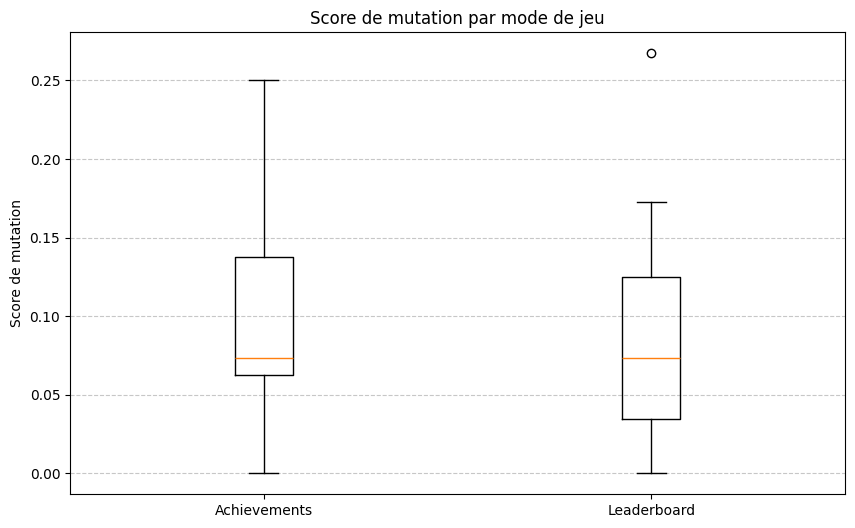

In [13]:
if not os.path.exists(pitest_figures_out):
    os.makedirs(pitest_figures_out)

plt.figure(figsize=(10, 6))
plt.boxplot([
    df_pitest[(df_pitest['game_mode'] == 'achievements')][col],
    df_pitest[(df_pitest['game_mode'] == 'leaderboard')][col]
], tick_labels=['Achievements', 'Leaderboard'])

plt.title('Score de mutation par mode de jeu')
plt.ylabel('Score de mutation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(f"{pitest_figures_out}/mutation_score_by_game_mode.pdf")
plt.show()

# Meilleur mode

In [14]:
from notebooks.analysis import tests

alpha = 0.05

leaderboard = df_pitest[df_pitest['game_mode'] == 'leaderboard'][col]
achievements = df_pitest[df_pitest['game_mode'] == 'achievements'][col]

assert len(leaderboard) == len(achievements), f"Mismatch in sample size for {col}"

# Test de normalité
_, p_normal_diff_leaderboard = stats.shapiro(leaderboard)
_, p_normal_diff_achievements = stats.shapiro(achievements)

# Test variance
stat, variance_p_value = stats.levene(leaderboard, achievements)

# Choix du test
if p_normal_diff_leaderboard > 0.05 and p_normal_diff_achievements > 0.05:
    t_stat, p_value = stats.ttest_ind(leaderboard, achievements, equal_var=True)
    test = "t-test"
else:
    t_stat, p_value = stats.mannwhitneyu(leaderboard, achievements)
    test = "Mann-Whitney U"

a12 = tests.vargha_delaney_a12(leaderboard, achievements)
a12_label = tests.a12_label(a12)
better_mode = "equals" if a12 == 0.5 else "leaderboard" if a12 > 0.5 else "achievements"

data = [
    col,
    p_normal_diff_leaderboard > 0.05,
    p_normal_diff_achievements > 0.05,
    variance_p_value > 0.05,
    test,
    p_value,
    p_value < alpha,
    a12,
    a12_label,
    better_mode
]

best_mode_df = pd.DataFrame([data], columns=[
    'metric',
    'leaderboard_normal',
    'achievements_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney',
    'better_mode',
])

best_mode_df

,metric,leaderboard_normal,achievements_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney,better_mode
0,mutation_coverage,True,True,True,t-test,0.768984,False,0.460938,Aucun effet,achievements
